In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from pathlib import Path
from began import build_discriminator, build_generator, build_adversarial_model, training_schedule

from IPython import display

In [2]:
data_dir = Path("../data/preprocessed")
training_data = np.load(data_dir / "GNILC_dust_map.npy")
MODEL_DIR = Path("../models")

In [3]:
training_data.shape

(1033, 256, 256, 1)

In [4]:
TRAIN_BUFF = 30000
BATCH_SIZE = 256

In [5]:
train_images = tf.data.Dataset.from_tensor_slices(training_data).shuffle(TRAIN_BUFF).batch(BATCH_SIZE)

(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUFF).batch(BATCH_SIZE)

In [6]:
# Network architecture
DEPTH = 32
IMG_DIM = 256
CHANNELS = 1
KERNELS = [5, 5, 5]
STRIDES = [2, 2, 2]
FILTERS = [DEPTH * 2 ** i for i in range(len(KERNELS))]
LATENT_DIM = 64

In [7]:
# Derived parameters
SHAPE = (IMG_DIM, IMG_DIM, CHANNELS)

In [8]:
# Training parameters
EPOCHS = 50

In [9]:
# Build inidividual and joint models.
DIS = build_discriminator(FILTERS, KERNELS, STRIDES, SHAPE)
GEN = build_generator(DIS, FILTERS, KERNELS, STRIDES, LATENT_DIM, SHAPE)
ADV = build_adversarial_model(DIS, GEN)
print(GEN.summary())

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_G (Dense)              (None, 131072)            8519680   
_________________________________________________________________
Reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
BNorm_G1 (BatchNormalization (None, 32, 32, 128)       512       
_________________________________________________________________
LRelu_G1 (LeakyReLU)         (None, 32, 32, 128)       0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 64, 64, 128)       0         
_________________________________________________________________
Conv2D_G1 (Conv2D)           (None, 64, 64, 64)        204864    
_________________________________________________________________
BN_G2 (BatchNormalization)   (None, 64, 64, 64)        25

In [10]:
print(DIS.summary())

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_D1 (Conv2D)           (None, 128, 128, 32)      832       
_________________________________________________________________
LRelu_D1 (LeakyReLU)         (None, 128, 128, 32)      0         
_________________________________________________________________
Conv2D_D2 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
BNorm_D1 (BatchNormalization (None, 64, 64, 64)        256       
_________________________________________________________________
LRelu_D2 (LeakyReLU)         (None, 64, 64, 64)        0         
_________________________________________________________________
Conv2D_D3 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
BNorm_D2 (BatchNormalization (None, 32, 32, 128)     

In [49]:
random_vector_for_generation = tf.random.normal(
    shape=[16, LATENT_DIM])

def training_schedule(discriminator, generator, adversarial_model, training_dataset,
    latent_dim=32, epochs=50, callback=False):
    """ Function to execute a training schedule for the GAN. 

    Each iteration of the GAN training process consists of two steps:

    i) Train the discriminator on a combination of real and fake data,  updating
    its weights. 

    ii) Hold the discriminator weights constant, and train the adversarial
    network. To train the adversarial network we give it a random vectors paired
    with a valid target. This trains the generator part of the GAN to produce
    images that the discriminator will classify as valid.

    Parameters
    ----------
    nbatch: int
        Size of batches to train on. This is only really useful if the training
        data can not fit in memory. If training data fits in memory, just use all
        at once.
    epochs: int
        Number of epochs (passes through whole data set) to train.
    """
    image_lat = np.random.randn(1, latent_dim)
    for epoch in range(epochs):
        print("Epoch: ", epoch)
        for step, image_batch in enumerate(training_dataset):
            if callback:
                tf.summary.experimental.set_step(step)
            batch_size = len(image_batch)
            # First train the discriminator with correct labels
            # Randomly select batch from training samples
            y_real = np.random.binomial(1, 0.99, size=[batch_size, 1])
            y_fake = np.random.binomial(1, 0.01, size=[batch_size, 1])

            # Use `generator` to create fake images.
            noise = np.random.normal(loc=0., scale=1., size=[batch_size, latent_dim])
            fake_images = generator.predict(noise)

            # Train the discriminator on real and fake images.
            real_loss = discriminator.train_on_batch(image_batch, y_real)
            fake_loss = discriminator.train_on_batch(fake_images, y_fake)
            d_loss = 0.5 * (real_loss + fake_loss)
            # Now train the adversarial network.
            # Create new fake images, and label as if they are from the training set.
            # Lie indicates that we are tricking the adversarial network by
            # telling it the target is valid, when in reality the discriminator
            # is being fed fake images by the generator.
            y_lie = np.ones([batch_size, 1])
            noise = np.random.normal(loc=0., scale=1., size=[batch_size, latent_dim])
            a_loss = adversarial_model.train_on_batch(noise, y_lie)
            if callback:
                tf.summary.image('random_draw', generator.predict(image_lat))
                tf.summary.scalar('aloss', a_loss)
                tf.summary.scalar('dloss', d_loss)
        generate_and_save_images(adversarial_model.get_layer('Generator'), epoch, random_vector_for_generation)
    return adversarial_model

def generate_and_save_images(generator, epoch, test_input):
    predictions = generator.predict(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


Epoch:  0


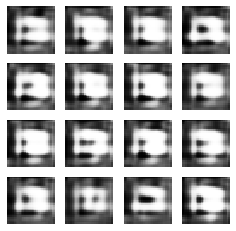

Epoch:  1


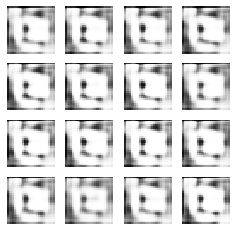

Epoch:  2


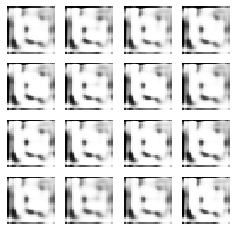

Epoch:  3


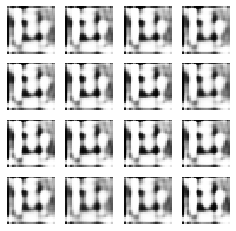

Epoch:  4


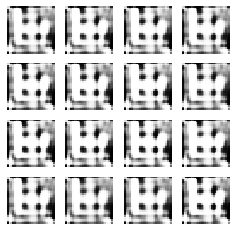

Epoch:  5


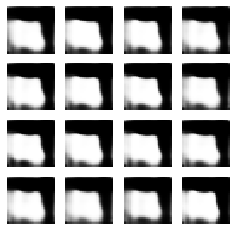

Epoch:  6


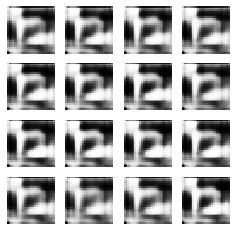

Epoch:  7


KeyboardInterrupt: 

In [50]:
trained_model = training_schedule(DIS, GEN, ADV, train_images, LATENT_DIM, EPOCHS)

In [ ]:
trained_model.save(str(MODEL_DIR / "dust_dcgan.h5"))

In [ ]:
plt.imshow(trained_model.get_layer('Generator').predict(np.random.randn(1, 64))[0, :, :, 0])